In [3]:
import sys
sys.path.append('src')
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [4]:
NE, N_syl, N_HVC_per_syl = 600, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [5]:
peak_rate, kernel_width = 150, 20

In [6]:
T_rend = 600 # Each rendition
N_rend = 10 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


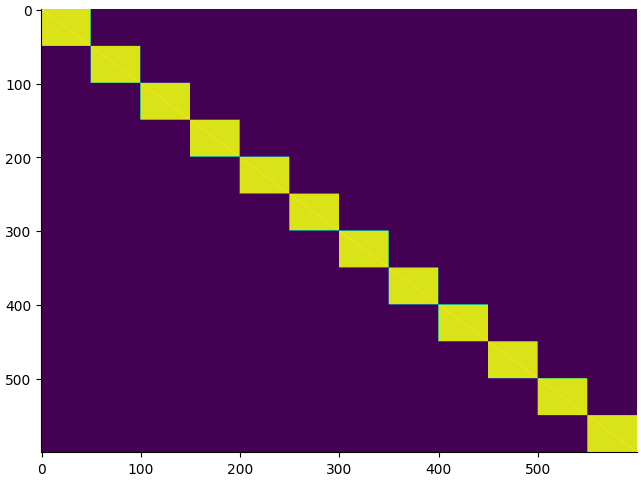

In [27]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 50
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [28]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [29]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [30]:
r_rest = 1 # target rate when phi(0)
rmax, s = 40, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [31]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [32]:
w0_mean = 1/N_HVC
w_inh = w0_mean
tauE, dt = 40, 1

net = WCNet(NE, N_HVC, w0_mean, phi, tauE, w_inh=w_inh)

rE0 = r_rest
_ = net.sim(rE0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-5e-2, w0_mean=w0_mean, tauW=1e5)
rE, _, Ws, mean_HVC_input = _

Not a recurrent model and rI will not be calculated.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6499/6499 [00:01<00:00, 5968.75it/s]


(<Figure size 400x450 with 3 Axes>,
 array([<Axes: ylabel='$\\left\\langle \\| W \\|_F \\right\\rangle$'>,
        <Axes: ylabel='mean input\nfrom HVC'>,
        <Axes: xlabel='Time (a.u.)', ylabel='Mean exc. rate'>],
       dtype=object))

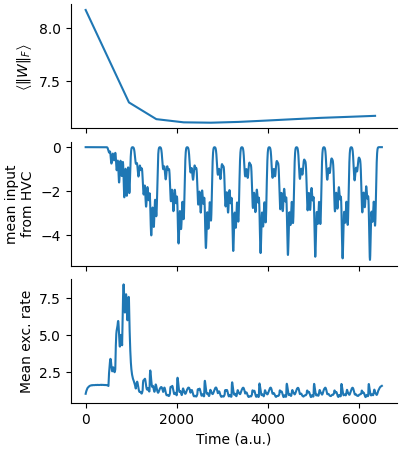

In [33]:
plot_train_stats(Ws, rE, mean_HVC_input, save_W_ts)

In [34]:
W_syl_corrs = [correlation(_.T, syl, dim=2) for _ in Ws]

/home/zg93/Projects/Aiv-Network/src/visualization.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


(<Figure size 700x200 with 5 Axes>,
 array([<Axes: title={'center': 'Rendition 0'}, ylabel='HVC index'>,
        <Axes: title={'center': 'Rendition 3'}>,
        <Axes: title={'center': 'Rendition 7'}>,
        <Axes: title={'center': 'Rendition 10'}>], dtype=object))

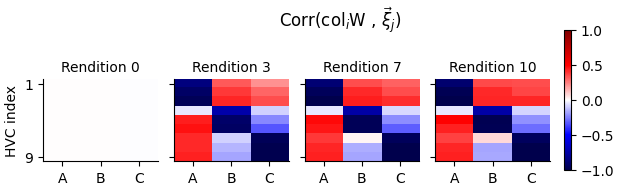

In [35]:
plot_wcol_corr(W_syl_corrs, (1, 4), (7, 2))

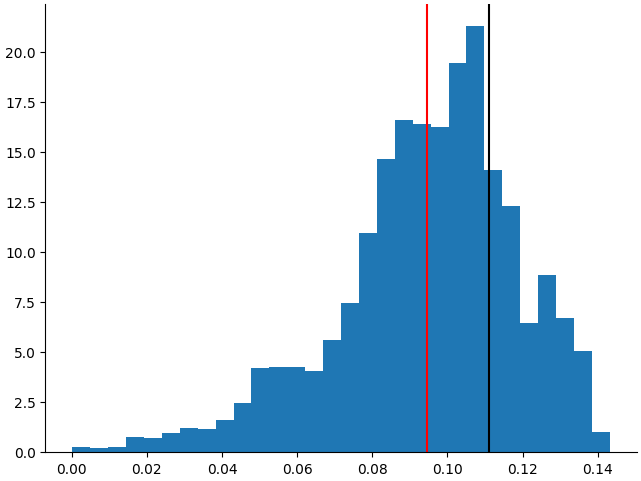

In [36]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')

## Test Model with Different Scenarios

In [37]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [38]:
exp = Experiment(net, rH, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert_args = [(pert_mean, pert_cov, 0)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.25s/it]


In [17]:
rE_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['rE']]
syl_block_avgs = block_apply(syl, K=N_shared_channels, func=np.mean)
bos_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['bos']]

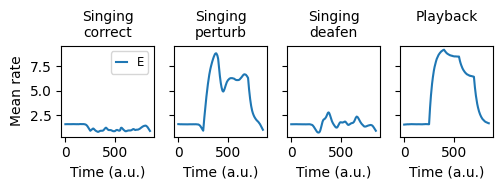

In [18]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all['rE'], tests_all['rI'], test_names, ti, tj, plot_inh=False)

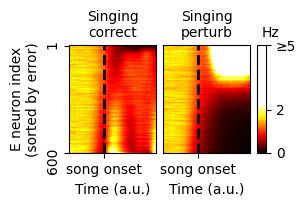

In [19]:
fig, ax = plot_raster_cmp_syl_dsyl(tests_all['rE'][0], tests_all['rE'][2], syl[0], 
                                   tests_all['bos'][2][0]-syl[0], 
                                   tsyl_start[0,0], tsyl_end[0,0], 
                                   figsize=(3, 2), plot_z=False, sort_by=('e', 'e'), th=5)

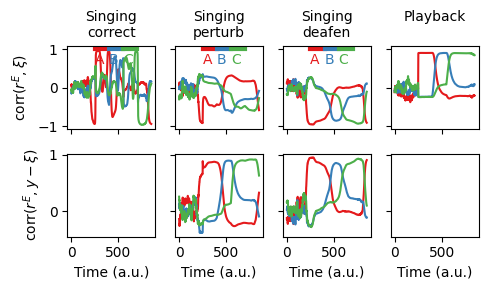

In [20]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(rE_block_avgs, bos_block_avgs, syl_block_avgs, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

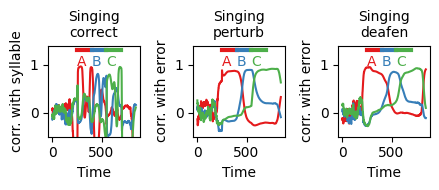

In [21]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(rE_block_avgs[:-1], bos_block_avgs[:-1], 
                                  syl_block_avgs, test_names[:-1],
                                  ti, tj, tid_perturb_input=(1, 2), 
                                  syl_order=so, y=1.3)

0 600


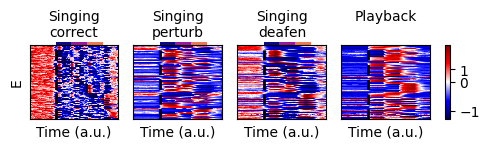

In [23]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all, test_names, ti, tj, T_burn, 
                            plot_inh=False, syl_order=so)

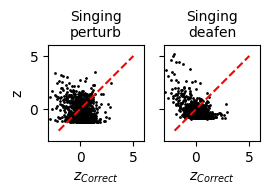

In [24]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(tests_all['rE'][:-1], test_names[:-1], ti, tj)
# fig, ax = plot_ctrl_vs_nonctrl(rE_block_avgs[:-1], test_names[:-1], ti, tj)

[(-1.0, 1.0)]

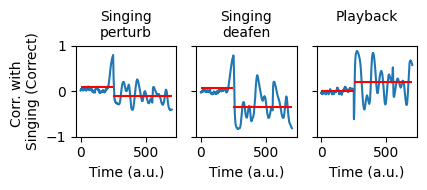

In [25]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all['rE'], test_names, ti, tj, T_burn)
# fig, ax = plot_corr_ctrl_nonctrl(rE_block_avgs, test_names, ti, tj, T_burn)
ax[0].set(ylim=[-1, 1])

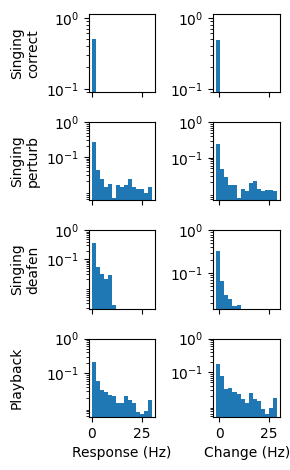

In [26]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all['rE'], test_names, tests_all['rE'][0], ti, tj)
# fig, ax = plot_rate_and_change_dists(rE_block_avgs, test_names, rE_block_avgs[0], ti, tj)

### Mismatch with perturbed patterns

In [30]:
T_test = T_burn + T_rend
perturb_type = 'SNR'
# perturb_type = 'ADD'
perturb_param = np.linspace(0, 1, num=11) 
tests, ovlps, corrs = [], [], []

for pm in perturb_param:
    syl_ = syl.copy()
    if perturb_type == 'SNR':
        pert_mean = np.ones(NE) * syl.mean() * pm
        pert_var = syl.var() * pm * (2 - pm)
        pert_cov = np.zeros((NE,NE))
        pert_cov[np.arange(NE),np.arange(NE)] = pert_var
        ret = exp.sim('perturb', pert_args=(pert_mean, pert_cov, 1 - pm))
    
    elif perturb_type == 'ADD':
        ret = exp.sim('perturb', pert_args=(np.zeros(NE), np.identity(NE) * pm, 1))
        
    else:
        raise NotImplementedError
    
    tests.append(ret[0])
    ovlps.append(ret[0][0] @ syl.T)
    if pm == 0:
        corrs.append(np.zeros((T_test,N_syl)))
    else:
        corrs.append(correlation(ret[0], ret[2] - syl, dim=2))

100%|████████████████████████████████████| 1099/1099 [00:00<00:00, 12016.43it/s]


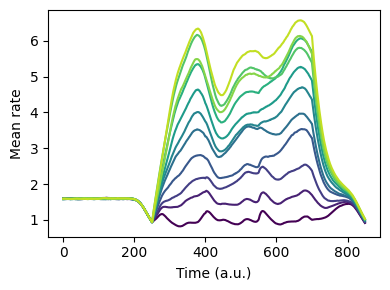

In [31]:
fig, ax = plt.subplots(1, sharey='all', sharex='all', figsize=(4, 3))
# for i in range(ax.shape[1]):
#     ax[-1,i].set(xlabel='Time (a.u.)')
cmap = colormaps.get_cmap('viridis')
for i, (pm, test) in enumerate(zip(perturb_param, tests)):
    ax.plot(test[T_burn//2:T_burn+T_rend].mean(axis=1), c=cmap(i/len(perturb_param)))
    
ax.set(xlabel='Time (a.u.)', ylabel='Mean rate')
fig.tight_layout()

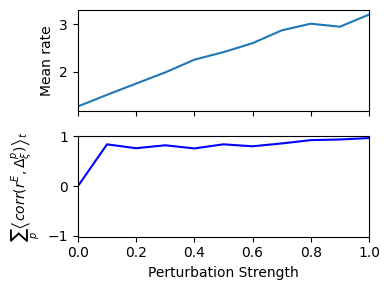

In [32]:
fig, ax = plt.subplots(2, sharex='all', figsize=(4, 3))
ax[0].plot(perturb_param, list(map(lambda x: x.mean(), tests)))
ax[1].plot(perturb_param, list(map(lambda x: x[T_burn:].sum(axis=1).mean(), corrs)), 
           color='b', label='Corr.')
ax[0].set(ylabel='Mean rate')
_ = np.abs(ax[1].get_ylim()).max()
ax[1].set(xlabel='Perturbation Strength', xlim=perturb_param[[0,-1]], ylim=[-_, _])
ax[1].set_ylabel(r'$\sum_p\left\langle corr(r^E, \Delta_\xi^p)\right\rangle_t$')
fig.tight_layout()